1: Read file, process signal , downsampling, save as csv ,
plot original, downsampling, filtered diagram

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 28.8 MB/s eta 0:00:00
Mounted at /content/drive
Start reading EDF file /content/drive/MyDrive/chb01_03.edf
Extracting EDF parameters from /content/drive/MyDrive/chb01_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/tmp/ipython-input-4272522576.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True)   #use mne to read a edf file, and return a raw object.


Reading 0 ... 921599  =      0.000 ...  3599.996 secs...
Original sampling frequency: 256.0 Hz
Channel name: ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9', 'FT9-FT10', 'FT10-T8', 'T8-P8-1']
<RawEDF | chb01_03.edf, 23 x 921600 (3600.0 s), ~161.7 MiB, data loaded>
process complete，CSV is saved /content/drive/MyDrive/F7-T7_downsampled.csv


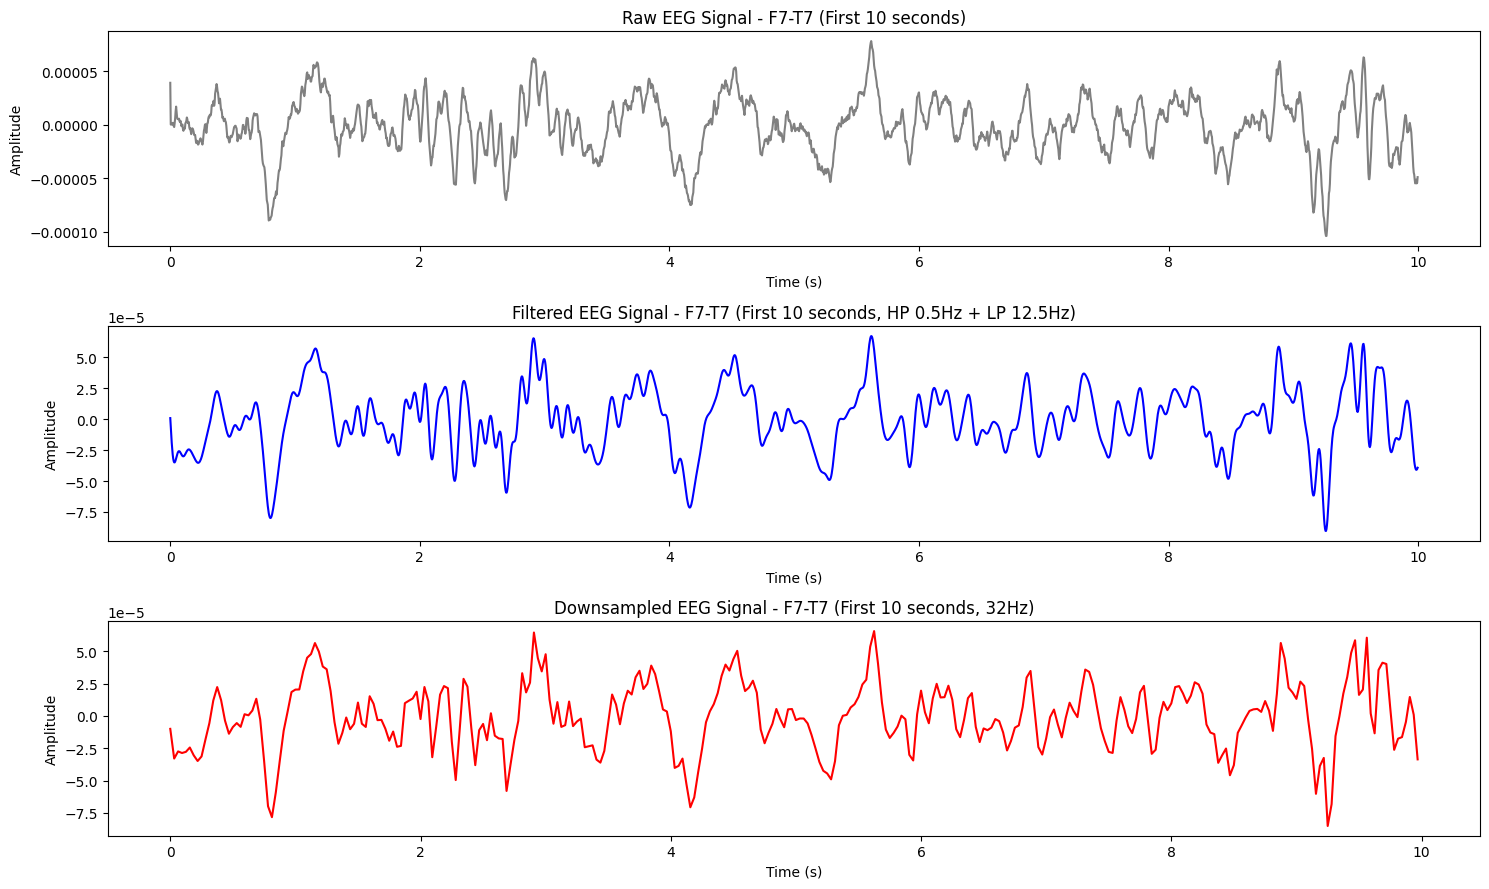

In [1]:
# 安装依赖
!pip install mne

import os
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, resample
from google.colab import drive

# 1) 挂载 Google Drive
drive.mount('/content/drive')

# 2) edf file path I use the chb01_03 which has a seizure.
edf_file = "/content/drive/MyDrive/chb01_03.edf"


# 3) define funcion 定义处理函数（读取+滤波+下采样+保存+可视化）
def process_eeg(edf_path,
                channel_name="F7-T7",
                hp_cutoff=0.5,
                lp_cutoff=12.5,
                target_fs=32,
                order=4,
                plot=True,
                save_dir="/content/drive/MyDrive"):
    """
    读取 EDF 文件，提取指定通道，进行带通滤波bandpass 高通(0.5Hz)与低通(12.5Hz)滤波，
    下采样到 target_fs，保存 CSV，并可视化。
    """
    print(f"Start reading EDF file {edf_path}")
    raw = mne.io.read_raw_edf(edf_path, preload=True)   #use mne to read a edf file, and return a raw object.
    sfreq = raw.info['sfreq']   # extract the original sampling frequency
    ch_names = raw.ch_names    # extract all the names of the channel
    print(f"Original sampling frequency: {sfreq} Hz")
    print(f"Channel name: {ch_names}")
    print(raw)  # print raw infomation

    if channel_name not in ch_names:
        raise ValueError(f"Selected {channel_name} is not in the list. Please select a valid name from above.")

    # 提取通道数据与时间轴（秒）extract the data of channel and time asix
    data, times = raw.get_data(picks=[channel_name], return_times=True)
    data = data[0]  # shape: (n_samples,)

    # define the filter function(bandpass filter)
    def butter_bandpass_filter(x, lowcut, highcut, fs, order=4):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        b, a = butter(order, [low, high], btype='band')
        y = filtfilt(b, a, x)
        return y

    # implement the bandpass instead low+high filter
    filtered = butter_bandpass_filter(data, hp_cutoff, lp_cutoff, sfreq, order = order)

    # downsampling to target_fs
    num_samples = int(len(filtered) * target_fs / sfreq)
    downsampled = resample(filtered, num_samples)
    down_times = np.linspace(0, len(filtered) / sfreq, num_samples, endpoint=False)

    # make sure the path is availiable
    os.makedirs(save_dir, exist_ok=True)
    out_csv = os.path.join(save_dir, f"{channel_name}_downsampled.csv")

    # save CSV
    pd.DataFrame({f"EEG_{channel_name}": downsampled}).to_csv(out_csv, index=False)
    print(f"process complete，CSV is saved {out_csv}")

    # visualize（ 10 s）
    if plot:  # only when plot = ture
        preview_sec = 10
        n_preview = int(sfreq * preview_sec)
        n_preview_down = int(target_fs * preview_sec)

        plt.figure(figsize=(15, 9))

        #  oringinal
        plt.subplot(3, 1, 1)
        plt.plot(times[:n_preview], data[:n_preview], color="gray")
        plt.title(f"Raw EEG Signal - {channel_name} (First {preview_sec} seconds)")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")

        #  filter
        plt.subplot(3, 1, 2)
        plt.plot(times[:n_preview], filtered[:n_preview], color="blue")
        plt.title(f"Filtered EEG Signal - {channel_name} (First {preview_sec} seconds, HP {hp_cutoff}Hz + LP {lp_cutoff}Hz)")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")

        #  downsampling
        plt.subplot(3, 1, 3)
        plt.plot(down_times[:n_preview_down], downsampled[:n_preview_down], color="red")
        plt.title(f"Downsampled EEG Signal - {channel_name} (First {preview_sec} seconds, {target_fs}Hz)")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")

        plt.tight_layout()
        plt.show()

    return {
        "sfreq": sfreq,
        "channel": channel_name,
        "raw_times": times,
        "raw_data": data,
        "filtered_data": filtered,
        "downsampled_times": down_times,
        "downsampled_data": downsampled,
        "csv_path": out_csv,
    }

# 5)  use fuction and visualize
result = process_eeg(
    edf_file,
    channel_name="F7-T7",
    hp_cutoff=0.5,
    lp_cutoff=12.5,
    target_fs=32,
    order=4,
    plot=True,
    save_dir="/content/drive/MyDrive"
)

2:Plot PSD diagram

Start reading EDF file /content/drive/MyDrive/chb01_03.edf
Extracting EDF parameters from /content/drive/MyDrive/chb01_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


/tmp/ipython-input-4272522576.py:33: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True)   #use mne to read a edf file, and return a raw object.


Original sampling frequency: 256.0 Hz
Channel name: ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9', 'FT9-FT10', 'FT10-T8', 'T8-P8-1']
<RawEDF | chb01_03.edf, 23 x 921600 (3600.0 s), ~161.7 MiB, data loaded>
process complete，CSV is saved /content/drive/MyDrive/F7-T7_downsampled.csv


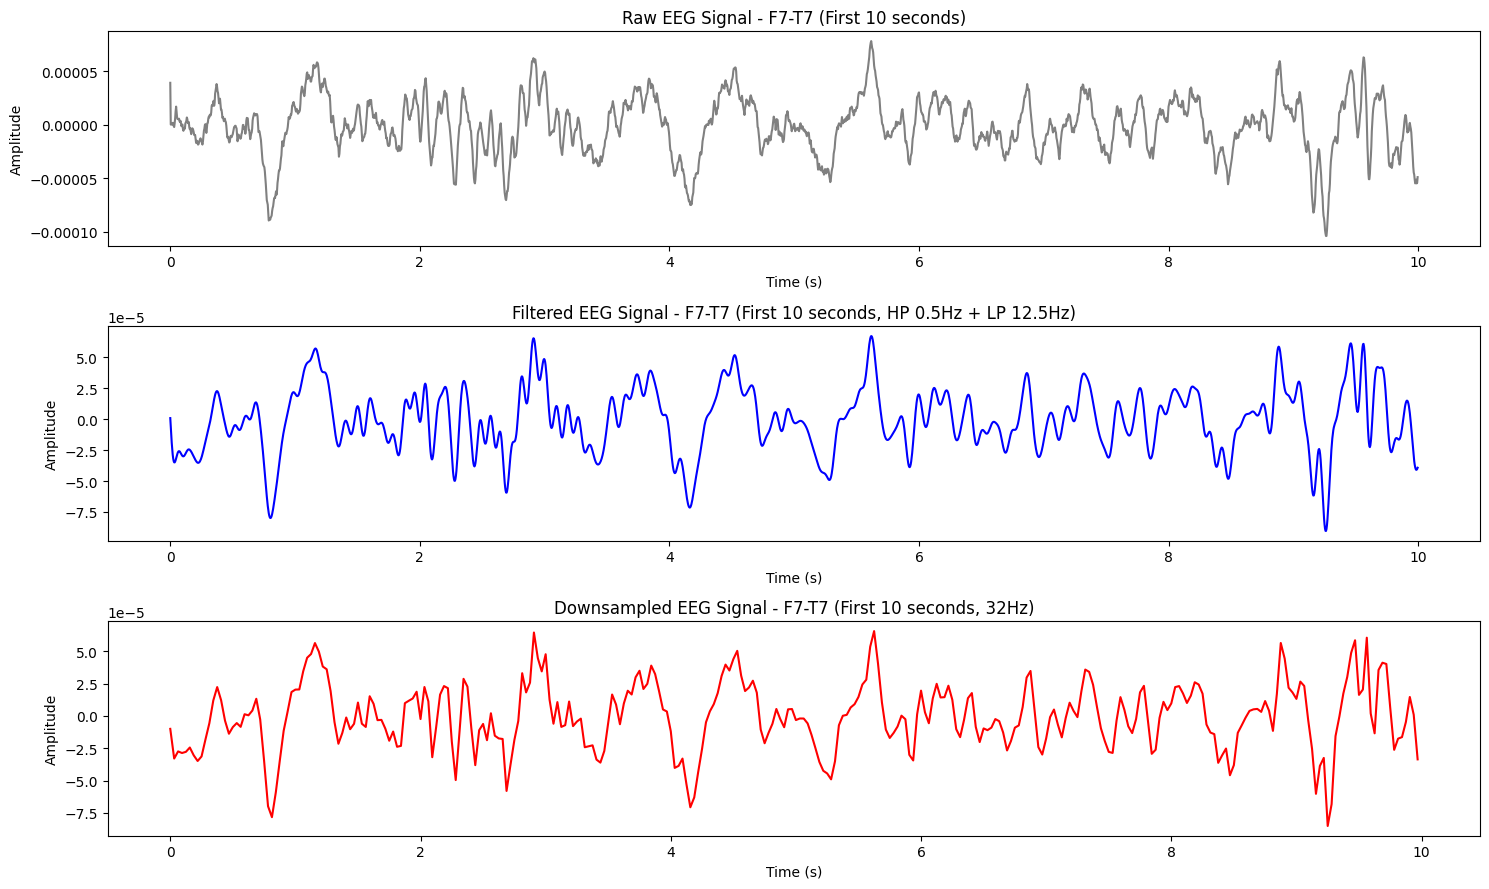

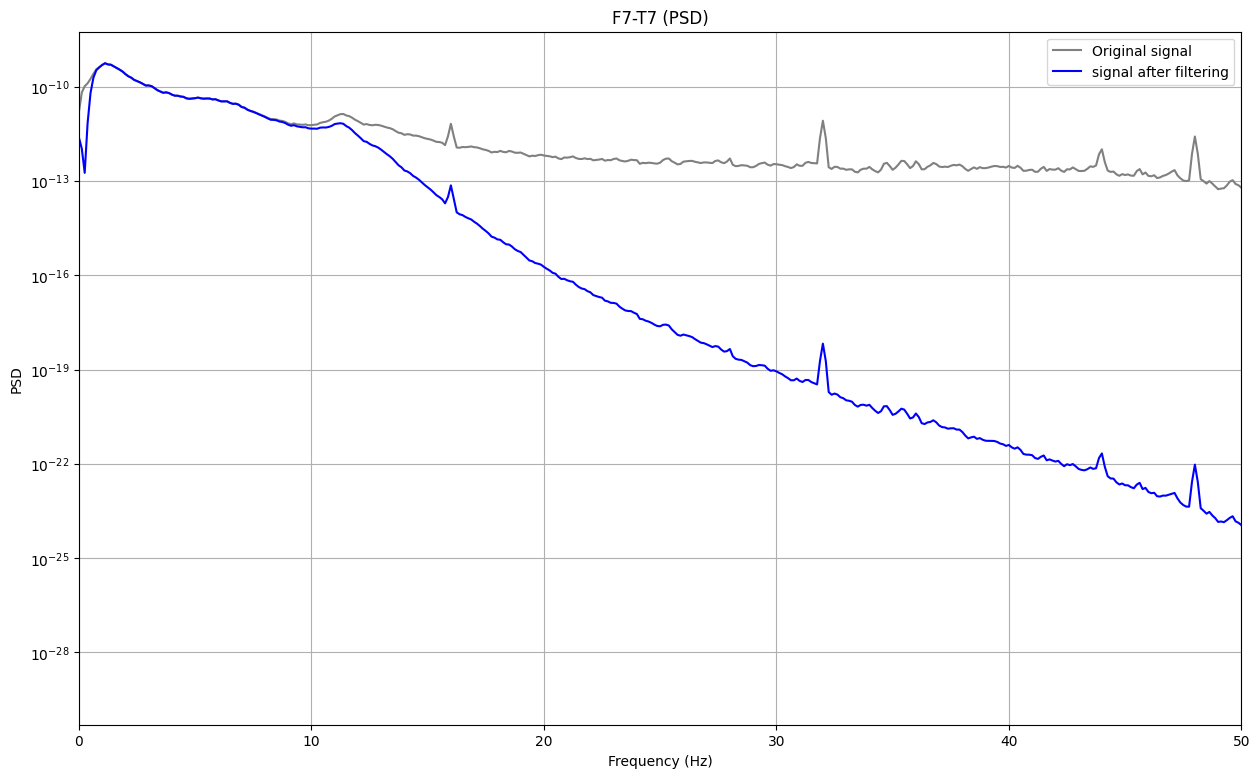

In [2]:
# plot the PSD diagram
from scipy.signal import welch

def plot_psd(raw_data, filtered_data, sfreq, channel_name="F7-T7"):

    # use Welch to calculate PSD
    f_raw, Pxx_raw = welch(raw_data, fs=sfreq, nperseg=2048)
    f_filt, Pxx_filt = welch(filtered_data, fs=sfreq, nperseg=2048)

    plt.figure(figsize=(15, 9))
    plt.semilogy(f_raw, Pxx_raw, color="gray", label="Original signal")
    plt.semilogy(f_filt, Pxx_filt, color="blue", label="signal after filtering")
    plt.title(f"{channel_name} (PSD)")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("PSD")
    plt.xlim(0, 50)  # only 0-50Hz ，common EEG spectrum
    plt.legend()
    plt.grid(True)
    plt.show()
result = process_eeg(edf_file, channel_name="F7-T7", plot=True)

plot_psd(result["raw_data"], result["filtered_data"], result["sfreq"], channel_name="F7-T7")

3: Get all the Channel

In [3]:
import mne
# 1) Read the EDF file
raw = mne.io.read_raw_edf(edf_file, preload=True)

# 2) Get data from all channels
eeg, times = raw.get_data(return_times=True)

print("EEG data shape:", eeg.shape)   # (n_channels, n_samples)
print("Sampling frequency:", raw.info['sfreq'])
print("Number of channels:", len(raw.ch_names))
print("Channel names:", raw.ch_names[:10], "...")  # Print the first 10 channel names to check

"""
This code uses the MNE library to read an EDF EEG file,
extract all channel data into a two‑dimensional NumPy array ([n_channels, n_samples]),
obtain the corresponding time axis, and then print out the sampling frequency,
the number of channels, and the names of the first few channels for inspection.
"""

Extracting EDF parameters from /content/drive/MyDrive/chb01_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


/tmp/ipython-input-539074251.py:3: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


EEG data shape: (23, 921600)
Sampling frequency: 256.0
Number of channels: 23
Channel names: ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4'] ...


'\nThis code uses the MNE library to read an EDF EEG file,\nextract all channel data into a two‑dimensional NumPy array ([n_channels, n_samples]),\nobtain the corresponding time axis, and then print out the sampling frequency,\nthe number of channels, and the names of the first few channels for inspection.\n'

4: Data segment

In [4]:
from typing import List, Tuple, Dict, Optional

def segment_eeg_into_epochs(
    eeg: np.ndarray,
    sfreq: float,
    epoch_len_s: float = 2.0,
    start_time_s: float = 0.0,
    allow_partial_last: bool = False,
    channels: Optional[List[str]] = None
) -> Dict[str, np.ndarray]:

    """
    将多通道 EEG 数据按固定时长切片为非重叠 epochs。

    参数
    ----
    eeg : np.ndarray
        形状为 [n_channels, n_samples] 的数组。每一行是一个通道的时序数据。
        要求已经完成预处理（去直流漂移、基础滤波等）。
    sfreq : float
        采样率（Hz），例如 CHB-MIT 数据通常为 256 Hz。
    epoch_len_s : float, 默认 2.0
        每个 epoch 的长度（秒）。论文采用 2 秒窗口以平衡非平稳性与生理相关性。
    start_time_s : float, 默认 0.0
        数据起始时间戳（秒）。如果你的数据是整段记录中的一部分，设置为该段相对开始时间。
    allow_partial_last : bool, 默认 False
        是否允许最后一个 epoch 为“部分窗口”（不足 epoch_len_s）。大多数检测流程设为 False，
        以保持特征维度一致。如果设为 True，则会包含一个长度不足的最后片段。
    channels : List[str] or None
        通道名列表（长度应为 n_channels）。用于后续日志、可视化和与标注对齐。
        若为 None，将自动生成 ['Ch0', 'Ch1', ...]。

    返回
    ----
    result : Dict[str, np.ndarray]
        - 'epochs': shape [n_epochs, n_channels, n_epoch_samples] 的三维数组。
        - 'epoch_start_sample': 每个 epoch 在原始数据中的起始样本索引。
        - 'epoch_end_sample': 每个 epoch 在原始数据中的结束样本索引（不含该端点）。
        - 'epoch_start_time': 每个 epoch 的起始时间戳（秒）。
        - 'epoch_end_time': 每个 epoch 的结束时间戳（秒）。
        - 'epoch_len_samples': 每个 epoch 的样本长度（通常为固定值）。
        - 'sfreq': 原始采样率（回传，便于后续处理链）。
        - 'channels': 通道名数组。
    """

    # 1) Input validation and shape unpacking
    if eeg.ndim != 2:
        raise ValueError("eeg must be 2D array of shape [n_channels, n_samples].")
    n_channels, n_samples = eeg.shape   # unpacking assignment

    # 2) Channel name handling: generate default names if not provided
    if channels is None:
        channels = np.array([f"Ch{i}" for i in range(n_channels)], dtype=object)
    else:
        channels = np.array(channels, dtype=object)
        if len(channels) != n_channels:
            raise ValueError("Length of channels must match n_channels.")

    # 3) Convert seconds to the number of samples: epoch_len_samples must be an integer for precise slicing
    epoch_len_samples = int(round(epoch_len_s * sfreq))
    if epoch_len_samples <= 0:
        raise ValueError("epoch_len_s too small given sfreq.")

    # 4) Compute the number of full epochs that can fit
    n_full_epochs = n_samples // epoch_len_samples  # Floor division
    remainder = n_samples % epoch_len_samples       # Remaining samples that don't form a full epoch

    # 5) Decide total number of epochs: whether to include the final partial segment
    if allow_partial_last and remainder > 0:
        n_epochs = n_full_epochs + 1
    else:
        n_epochs = n_full_epochs

    # 6) Allocate space for output
# Note: If allow_partial_last=True, the last epoch may be shorter than epoch_len_samples.
# For simplicity, I use a fixed-size array; if the last epoch is partial, we zero-pad the tail and record the true end_sample.
    epochs = np.zeros((n_epochs, n_channels, epoch_len_samples), dtype=eeg.dtype)
    epoch_start_sample = np.zeros(n_epochs, dtype=int)
    epoch_end_sample = np.zeros(n_epochs, dtype=int)
    epoch_start_time = np.zeros(n_epochs, dtype=float)
    epoch_end_time = np.zeros(n_epochs, dtype=float)

    # 7) Fill each epoch one by one
    for i in range(n_epochs):
        start = i * epoch_len_samples
        # Compute the theoretical end index of this epoch (exclusive)
        end = min(start + epoch_len_samples, n_samples)

        # Store sample indices and timestamps
        epoch_start_sample[i] = start
        epoch_end_sample[i] = end
        epoch_start_time[i] = start_time_s + start / sfreq
        epoch_end_time[i] = start_time_s + end / sfreq

        # Slice and store into output array
        # If the last epoch is a partial window, zero-pad to fixed length (commonly used to maintain consistent feature dimensions)
        segment = eeg[:, start:end]
        seg_len = segment.shape[1]
        epochs[i, :, :seg_len] = segment
        # If seg_len < epoch_len_samples, the remaining part stays as zeros (or optionally filled with NaN depending on downstream preferences)

    # 8) Aggregate output
    result = {
        "epochs": epochs,
        "epoch_start_sample": epoch_start_sample,
        "epoch_end_sample": epoch_end_sample,
        "epoch_start_time": epoch_start_time,
        "epoch_end_time": epoch_end_time,
        "epoch_len_samples": np.full(n_epochs, epoch_len_samples, dtype=int),
        "sfreq": np.array(sfreq, dtype=float),
        "channels": channels,
    }
    return result

Plot the first epoch

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Extracting EDF parameters from /content/drive/MyDrive/chb01_03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


/tmp/ipython-input-1955071531.py:15: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Shape of epochs: (1800, 23, 512)
Number of epochs: 1800
Length of each epoch (in samples): 512
Length of each epoch (in seconds): 2.0


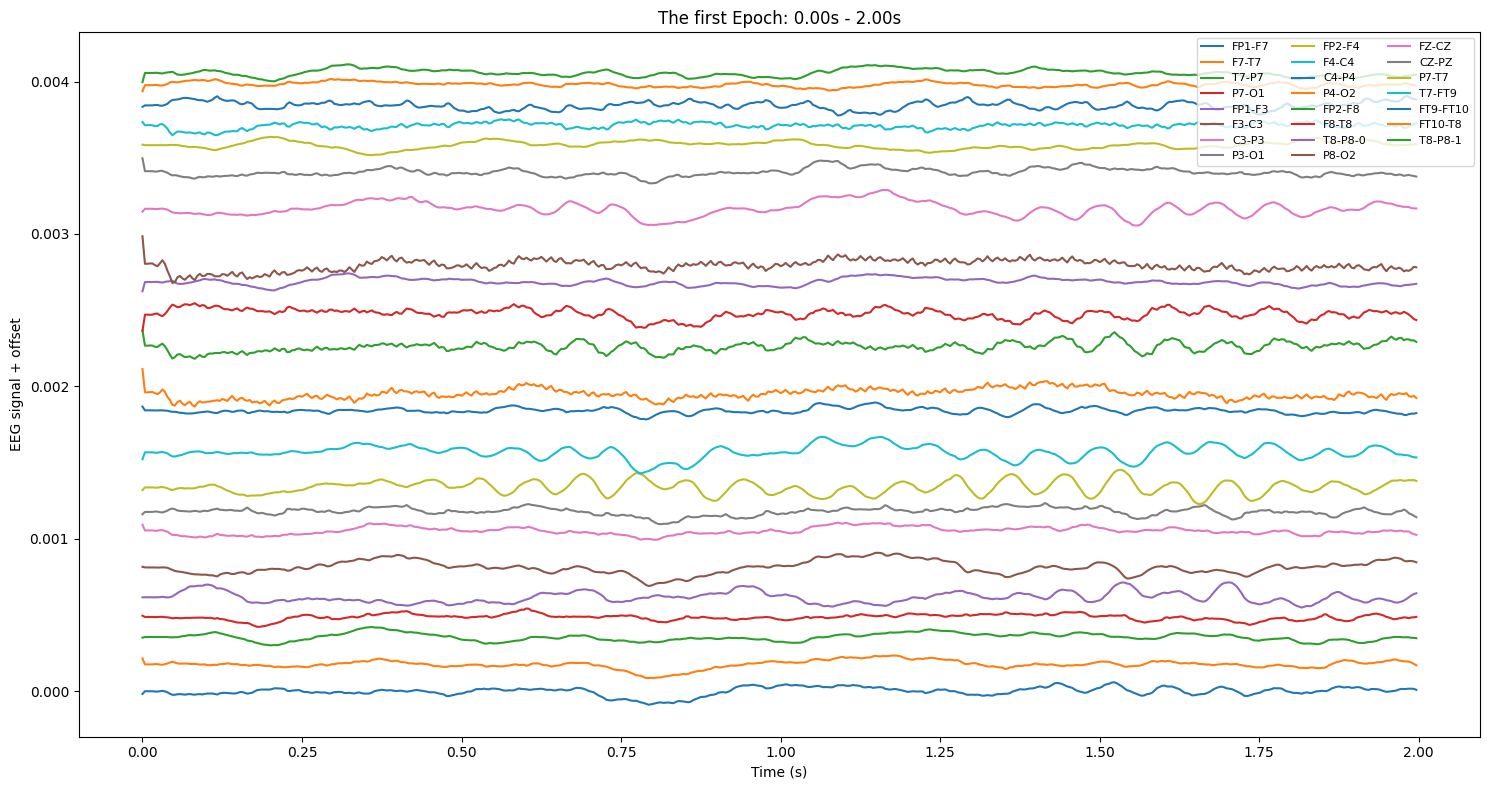

In [5]:
import mne
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive

# Assuming 'edf_file' is available from a previous cell where it's defined
# 1) Mount Google Drive
drive.mount('/content/drive')

# 2) edf file path I use the chb01_03 which has a seizure.
edf_file = "/content/drive/MyDrive/chb01_03.edf"


# 3) Read the EDF file
raw = mne.io.read_raw_edf(edf_file, preload=True)
sfreq = raw.info['sfreq']

# Get the EEG data and channel names from the raw object
eeg_data, times = raw.get_data(return_times=True)
channel_names = raw.ch_names

# Call the segmentation function
seg = segment_eeg_into_epochs(eeg_data, sfreq, channels=channel_names)

# Display some information about the segmented data
print("Shape of epochs:", seg['epochs'].shape)
print("Number of epochs:", len(seg['epochs']))
print("Length of each epoch (in samples):", seg['epoch_len_samples'][0])
print("Length of each epoch (in seconds):", seg['epoch_len_samples'][0] / seg['sfreq'])


# 1. extract the first epoch
first_epoch = seg["epochs"][0]   # shape (18, 512)
time_axis = np.arange(first_epoch.shape[1]) / seg["sfreq"]  # convert to seconds

# 2. Plot

plt.figure(figsize=(15, 8))
offset = 0
for ch_idx in range(seg["channels"].shape[0]):
    plt.plot(time_axis, first_epoch[ch_idx] + offset, label=seg["channels"][ch_idx])
    offset += np.max(np.abs(first_epoch[ch_idx])) * 2  # spare some space for each channel

plt.title(f"The first Epoch: {seg['epoch_start_time'][0]:.2f}s - {seg['epoch_end_time'][0]:.2f}s")
plt.xlabel("Time (s)")
plt.ylabel("EEG signal + offset")
plt.legend(loc="upper right", fontsize=8, ncol=3)
plt.tight_layout()
plt.show()

In [6]:
# Assuming 'raw' and 'sfreq' are available from previous steps (e.g., from loading the EDF file)
# If not, you'll need to run the code to load the data first.

# Get the EEG data and channel names from the raw object
eeg_data, times = raw.get_data(return_times=True)
channel_names = raw.ch_names

# Call the segmentation function
seg = segment_eeg_into_epochs(eeg_data, sfreq, channels=channel_names)

# Display some information about the segmented data
print("Shape of epochs:", seg['epochs'].shape)
print("Number of epochs:", len(seg['epochs']))
print("Length of each epoch (in samples):", seg['epoch_len_samples'][0])
print("Length of each epoch (in seconds):", seg['epoch_len_samples'][0] / seg['sfreq'])

Shape of epochs: (1800, 23, 512)
Number of epochs: 1800
Length of each epoch (in samples): 512
Length of each epoch (in seconds): 2.0


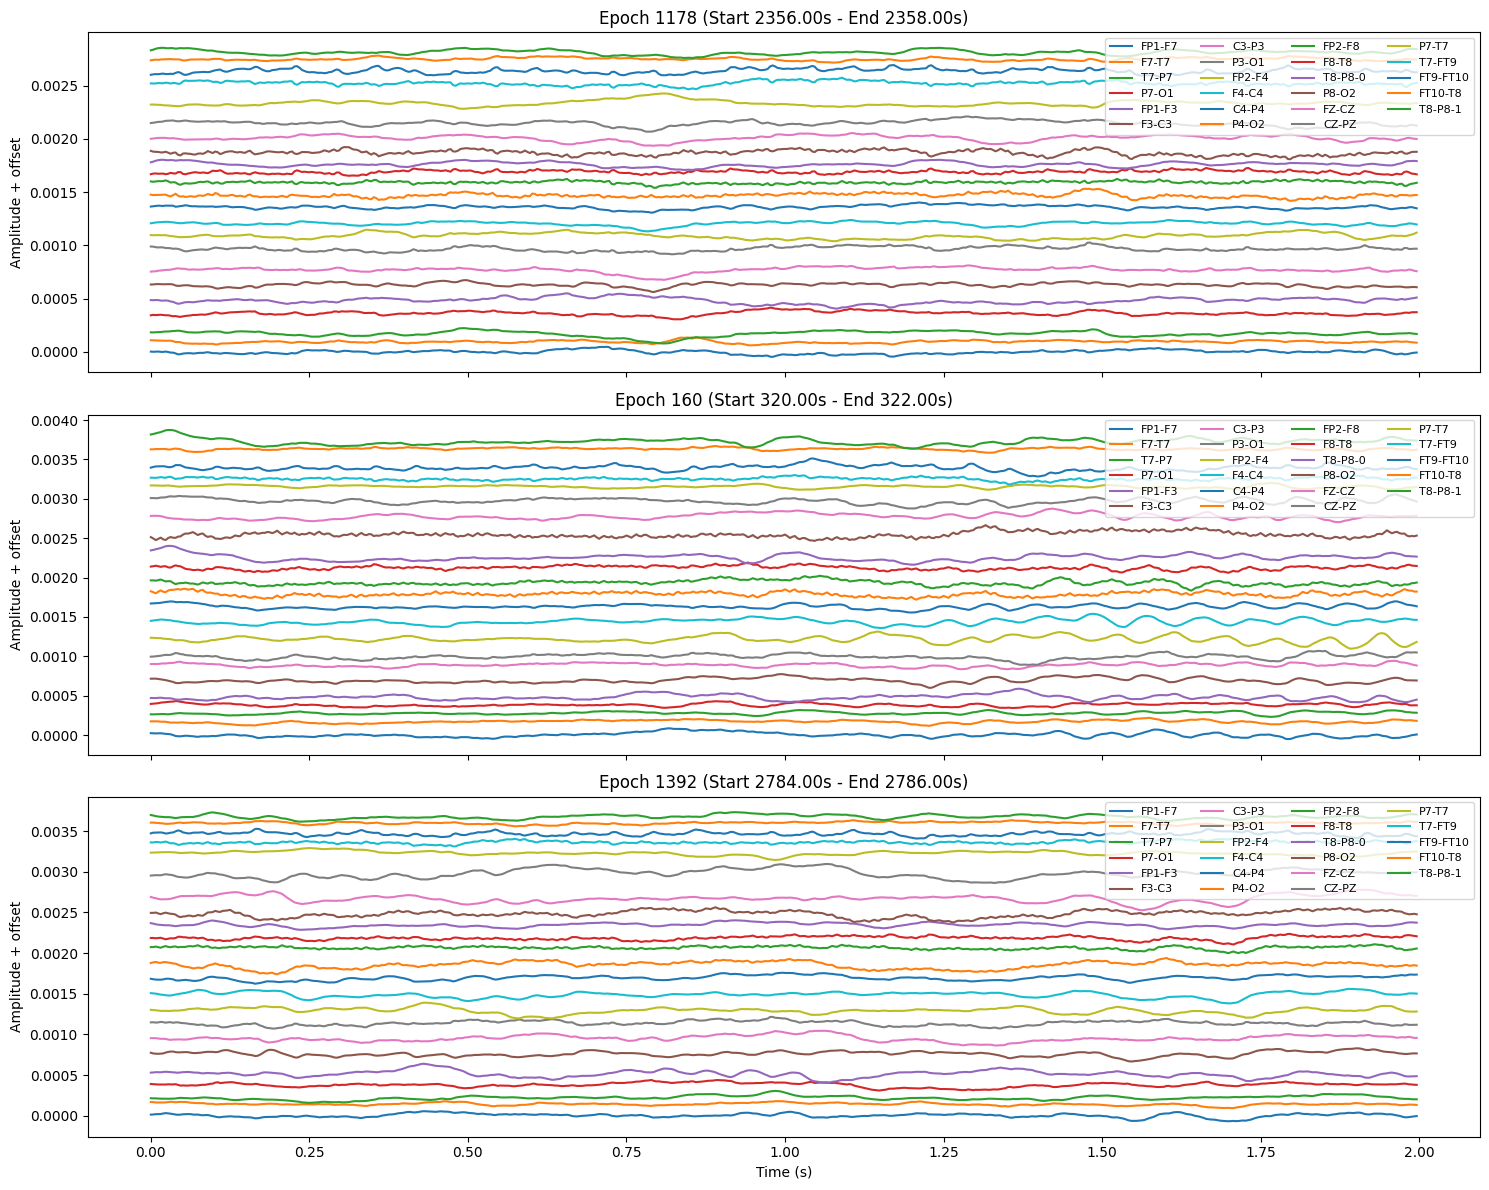

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def plot_random_epochs(result: dict, n_epochs_to_plot: int = 3, random_state: int = 42):
    """
    随机挑选若干个 epoch 并绘制波形。

    参数
    ----------
    result : dict
        segment_eeg_into_epochs 的输出字典。
    n_epochs_to_plot : int, 默认 3
        要绘制的 epoch 数量。
    random_state : int, 默认 42
        随机种子，保证结果可复现。
    """
    epochs = result["epochs"]          # (n_epochs, n_channels, epoch_len_samples)
    sfreq = result["sfreq"]            # 采样率
    channels = result["channels"]      # 通道名
    n_epochs, n_channels, epoch_len_samples = epochs.shape

    # 随机挑选 epoch 索引
    rng = np.random.default_rng(random_state)
    chosen = rng.choice(n_epochs, size=min(n_epochs_to_plot, n_epochs), replace=False)

    time_axis = np.arange(epoch_len_samples) / sfreq  # 每个 epoch 内的时间轴（秒）

    # 绘制
    fig, axes = plt.subplots(len(chosen), 1, figsize=(15, 4 * len(chosen)), sharex=True)

    if len(chosen) == 1:
        axes = [axes]  # 保证 axes 可迭代

    for ax, idx in zip(axes, chosen):
        epoch_data = epochs[idx]  # (n_channels, epoch_len_samples)
        offset = 0
        for ch_idx in range(n_channels):
            ax.plot(time_axis, epoch_data[ch_idx] + offset, label=channels[ch_idx])
            offset += np.max(np.abs(epoch_data[ch_idx])) * 2  # 给每个通道留出间隔

        ax.set_title(f"Epoch {idx} (Start {result['epoch_start_time'][idx]:.2f}s - "
                     f"End {result['epoch_end_time'][idx]:.2f}s)")
        ax.set_ylabel("Amplitude + offset")
        ax.legend(loc="upper right", fontsize=8, ncol=4)

    axes[-1].set_xlabel("Time (s)")
    plt.tight_layout()
    plt.show()
# 假设你已经运行了 segment_eeg_into_epochs 得到 result
plot_random_epochs(seg, n_epochs_to_plot=3)

spectrum analysis

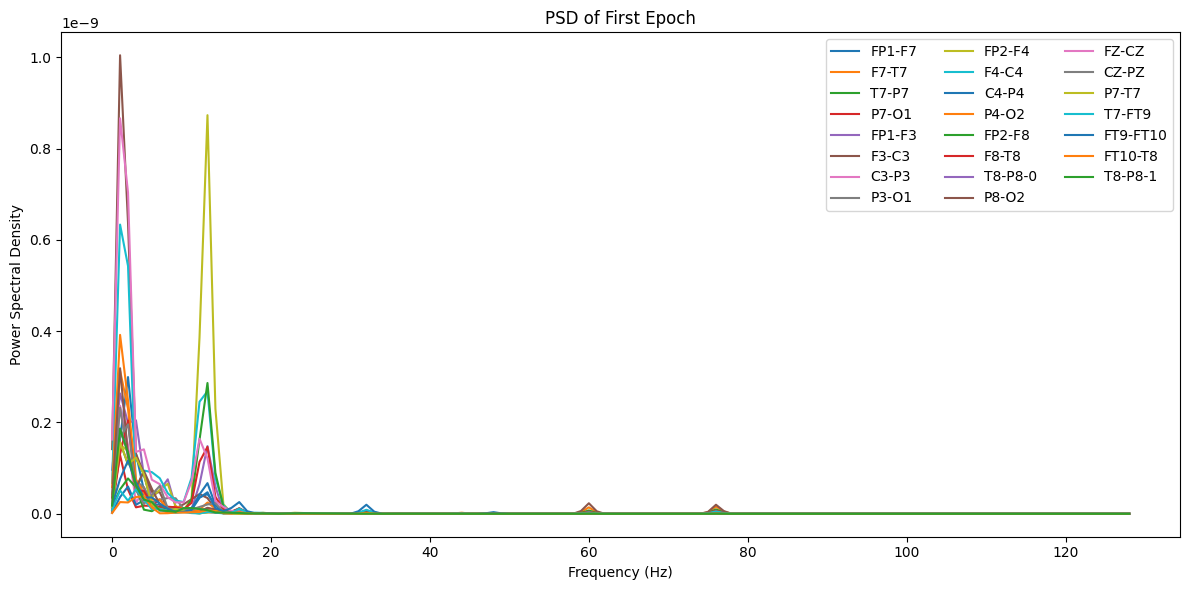

In [9]:
from scipy.signal import welch

# computer the first PSD of a epoch
f, psd = welch(seg["epochs"][0], fs=seg["sfreq"], axis=1)

plt.figure(figsize=(12, 6))
for ch_idx in range(psd.shape[0]):
    plt.plot(f, psd[ch_idx], label=seg["channels"][ch_idx])
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density")
plt.title("PSD of First Epoch")
plt.legend(ncol=3)
plt.tight_layout()
plt.show()


In [10]:
eeg_data = seg["epochs"].reshape(-1, seg["epochs"].shape[1])  # Merge all epochs into one long matrix → shape becomes (n_epochs * epoch_len_samples, n_channels)
eeg_data = eeg_data.T  # Transpose → shape becomes (n_channels, total_samples)

stats = {
    "mean": np.mean(eeg_data, axis=1),
    "std": np.std(eeg_data, axis=1), ##auc
    "max": np.max(eeg_data, axis=1),
    "min": np.min(eeg_data, axis=1),
}

df_stats = pd.DataFrame(stats, index=seg["channels"])
print(df_stats.round(3))


          mean  std    max    min
FP1-F7     0.0  0.0  0.001 -0.001
F7-T7      0.0  0.0  0.001 -0.001
T7-P7      0.0  0.0  0.001 -0.000
P7-O1      0.0  0.0  0.001 -0.001
FP1-F3     0.0  0.0  0.001 -0.001
F3-C3      0.0  0.0  0.001 -0.001
C3-P3      0.0  0.0  0.000 -0.001
P3-O1      0.0  0.0  0.001 -0.001
FP2-F4     0.0  0.0  0.001 -0.001
F4-C4      0.0  0.0  0.001 -0.001
C4-P4      0.0  0.0  0.001 -0.001
P4-O2      0.0  0.0  0.001 -0.001
FP2-F8     0.0  0.0  0.001 -0.001
F8-T8      0.0  0.0  0.001 -0.001
T8-P8-0    0.0  0.0  0.001 -0.001
P8-O2      0.0  0.0  0.001 -0.001
FZ-CZ      0.0  0.0  0.001 -0.001
CZ-PZ      0.0  0.0  0.001 -0.001
P7-T7      0.0  0.0  0.001 -0.001
T7-FT9     0.0  0.0  0.001 -0.001
FT9-FT10   0.0  0.0  0.001 -0.001
FT10-T8    0.0  0.0  0.001 -0.001
T8-P8-1    0.0  0.0  0.001 -0.001


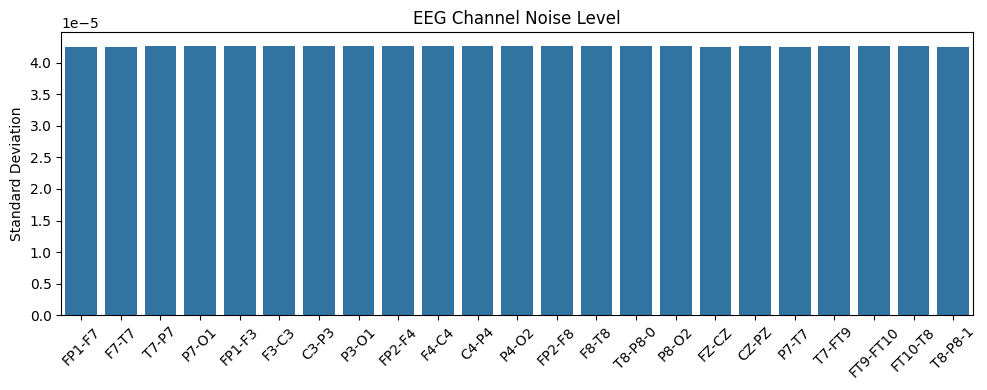

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
sns.barplot(x=seg["channels"], y=df_stats["std"])
plt.xticks(rotation=45)
plt.ylabel("Standard Deviation")
plt.title("EEG Channel Noise Level")
plt.tight_layout()
plt.show()


研究auc，maximizes 这个大小。
先提取特征向量，然后一点点数据的放入svm来训练，通过auc来判断特异性，准确性等特征。